En esta actividad, intentaré predecir la calificación final de los estudiantes utilizando el archivo A1.5 Calificaciones.csv. Para ello, analizaré la información demográfica de los alumnos junto con sus calificaciones en los dos primeros periodos del curso. Mediante técnicas de análisis de datos y modelos de regresión, buscaré identificar patrones que permitan estimar el desempeño final de cada estudiante. Este proceso no solo permitirá comprender mejor la relación entre los distintos factores académicos y personales, sino que también ayudará a evaluar la efectividad del modelo predictivo en la estimación de resultados finales.

La base de datos cuenta con la siguiente información.


*   "Escuela", Indica si el estudiante en cuestión asistía a la escuela Gabriel Pereira (GP) o a la escuela Mousinho da Silveira (MS)
*   "Sexo" . F para mujeres y H para hombres.
*   " Edad" . Edad del estudiante, en años .
*   "HorasDeEstudio" . Cantidad de horas de estudio: 1 indica menos de dos horas, 2 indica de dos a cinco horas, 3 indica de cinco a diez horas, 4 indica más de diez horas.
*   "Reprobadas". Indica la cantidad de materias reprobadas previamente.
*   "Internet" . Si el estudiante tenía acceso (yes) o no (no) a internet en su casaa.
*   "Faltas" . Cantidad de veces que faltó a clases
*   "G1". Calificación del primer periodo, escala del 0 al 20.
*   "G2". Calificación del segundo periodo, escala del 0 al 20.
*   "G3". Calificación final, escala del 0 al 20.











In [ ]:
# Primero importo las librerias necesarias
import pandas as pd

# A continuación se importa el archivo
datos = pd.read_csv('A1.5 Calificaciones.csv')
print(datos.dtypes) # Se imprime e tipo de dato  de cada variable

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


A continuación, realizaré la transformación de las variables categóricas para que puedan ser utilizadas en un modelo de regresión lineal múltiple. Algunas variables, aunque contienen valores numéricos, representan categorías en lugar de cantidades continuas, por lo que es necesario recodificarlas de manera adecuada. Una vez realizadas las modificaciones, mostraré las primeras cinco observaciones de la base de datos para verificar que las variables categóricas han sido correctamente convertidas en representaciones numéricas apropiadas.

In [ ]:
# Variables categoricas que puede identificar
categorical_vars = ['Escuela', 'Sexo', 'Internet']

# Se convierten en variables dummy
datos_encoded = pd.get_dummies(datos, columns=categorical_vars, drop_first=True)

# Se verifica que si son variables categoricas
datos_encoded['HorasDeEstudio'] = datos_encoded['HorasDeEstudio'].astype('category')
datos_encoded['Reprobadas'] = datos_encoded['Reprobadas'].astype('category')

# Convertir a variables dummy
datos_encoded = pd.get_dummies(datos_encoded, columns=['HorasDeEstudio', 'Reprobadas'], drop_first=True)

# 4. Imprimir las primeras 5 observaciones del dataset modificado
print(datos_encoded.head())

   Edad  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18       6   5   6   6       False   False         False   
1    17       4   5   5   6       False   False          True   
2    15      10   7   8  10       False   False          True   
3    15       2  15  14  15       False   False          True   
4    16       4   6  10  10       False   False         False   

   HorasDeEstudio_2  HorasDeEstudio_3  HorasDeEstudio_4  Reprobadas_1  \
0              True             False             False         False   
1              True             False             False         False   
2              True             False             False         False   
3             False              True             False         False   
4              True             False             False         False   

   Reprobadas_2  Reprobadas_3  
0         False         False  
1         False         False  
2         False          True  
3         False         False  
4         

A continuación, identificaré los valores atípicos en la variable "Faltas" usando el método de Tukey, que ayuda a detectar datos que se alejan demasiado del resto. Para esto, calcularé los cuartiles y el rango intercuartílico (IQR) y encontraré las observaciones que sean demasiado altas o bajas.

Después de detectar los valores atípicos, los analizaré para decidir si es necesario eliminarlos o mantenerlos. Finalmente, mostraré en consola los datos detectados y explicaré qué haré con ellos y por qué.

In [ ]:
import numpy as np

# Calcular los cuartiles y rango intercuartílico
q1 = datos.Faltas.quantile(0.25) # Primer cuartil (25%)
q3 = datos.Faltas.quantile(0.75) # Tercer cuartil (75%)
iqr = q3 - q1 # Rango intercuartílico

# Limites con k=3
li = q1 - 3 * iqr # Limite inferior
ls = q3 + 3 * iqr # Limite superior

# Encontrar los valores atípicos y convertir a una lista 1D
out = np.where((datos.Faltas < li) | (datos.Faltas > ls))[0] # Obtener solo los índices

# Imprimir valores atípicos
print(datos.iloc[out])

# Se eliminan valores atípicos usando los índices 1D, se convierte out a una lista simple
datos = datos.drop(index=out.tolist()) # Se convierte out a una lista usando .tolist()


    Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  \
74       GP    F    16               2           0      yes      54  11  12   
183      GP    F    17               2           0      yes      56   9   9   
276      GP    F    18               2           0      yes      75  10   9   
307      GP    M    19               1           1      yes      38   8   9   
315      GP    F    19               3           1      yes      40  13  11   

     G3  
74   11  
183   8  
276   9  
307   8  
315  11  


Voy a generar una matriz de correlaciones para ver qué tan relacionadas están las variables entre sí y detectar posibles problemas de colinealidad. Si dos o más variables están muy correlacionadas, podrían afectar el modelo de regresión.

Para entenderlo mejor, haré un heatmap que mostrará gráficamente la fuerza de estas relaciones. Con base en esto, decidiré si es necesario eliminar alguna variable para evitar redundancias y mejorar el modelo, explicando el motivo de los cambios si los hago.

Índices de las variables con mayor correlación: 8, 9
Correlación máxima: 0.9047966735871241


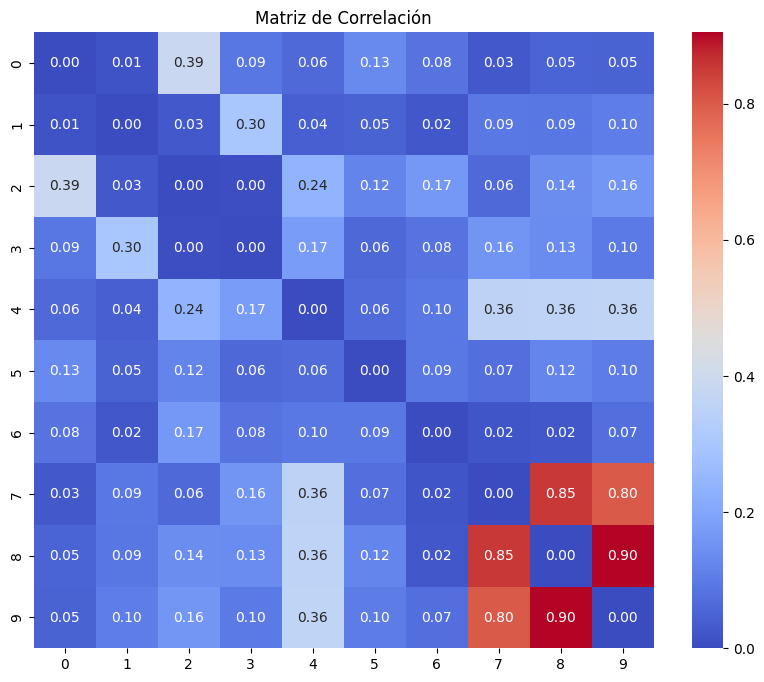

In [ ]:
# Se importa librerias necesarias
import seaborn as sns # Importar seaborn como sns
import matplotlib.pyplot as plt

# Convert all object type columns to numerical using pd.factorize
for col in datos.select_dtypes(include=['object','category']).columns:
    datos[col], _ = pd.factorize(datos[col])

# Calcular la matriz de correlación
cor = abs(np.corrcoef(datos, rowvar=False))
np.fill_diagonal(cor, 0) # Diagonal de ceros

# Encontrar los índices de la posición del valor máximo en la matriz de correlación
i, j = np.unravel_index(cor.argmax(), cor.shape)

# Imprimir los índices y el valor de la correlación más alta
print(f"Índices de las variables con mayor correlación: {i}, {j}")
print(f"Correlación máxima: {cor[i, j]}")

# Generar un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

Como se puede observar, la correlación más alta en la matriz es entre las variables G2 y G3, con un valor de 0.90. Esto indica una relación muy fuerte, lo que podría generar problemas de colinealidad en un modelo de regresión.

Sin embargo, dado que ambas variables representan calificaciones en distintos periodos, se considera útil mantenerlas para analizar cómo el desempeño en el segundo periodo (G2) influye en la calificación final (G3). Por lo tanto, en este análisis no se eliminará ninguna variable.

Ahora voy a agregar términos de interacción entre dos pares de variables para ver si su combinación tiene un impacto en la calificación final. Esto nos ayuda a entender mejor cómo una variable puede afectar a otra cuando actúan juntas.

Voy a elegir solo algunas combinaciones que me parezcan interesantes en lugar de hacer todas las posibles. Al final, imprimiré las primeras cinco filas del dataset para verificar que los nuevos términos se añadieron correctamente.

In [ ]:
# Importar librerías necesarias
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(datos.drop("G3",axis=1),datos.G3,train_size = 0.8)

# Mostrar dimensiones de los conjuntos
print("Tamaño de los datos:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Términos de interacción (train)
X_train.insert(2, "Horas_Edad", X_train["HorasDeEstudio"] * X_train["Edad"])
X_train.insert(3, "Reprobadas_Internet", X_train["Reprobadas"] * X_train["Internet"])

# Términos de interacción (test)
X_test.insert(2, "Horas_Edad", X_test["HorasDeEstudio"] * X_test["Edad"])
X_test.insert(3, "Reprobadas_Internet", X_test["Reprobadas"] * X_test["Internet"])

# Imprimir las primeras 5 observaciones de X_train
print("\nPrimeras 5 observaciones de X_train:")
print(X_train.head())

# Imprimir las primeras 5 observaciones de X_test
print("\nPrimeras 5 observaciones de X_test:")
print(X_test.head())

Tamaño de los datos:
X_train: (312, 9)
X_test: (78, 9)
y_train: (312,)
y_test: (78,)

Primeras 5 observaciones de X_train:
     Escuela  Sexo  Horas_Edad  Reprobadas_Internet  Edad  HorasDeEstudio  \
303        0     0          68                    0    17               4   
163        0     1          17                    0    17               1   
8          0     1          30                    0    15               2   
78         0     1          17                    3    17               1   
230        0     0          34                    0    17               2   

     Reprobadas  Internet  Faltas  G1  G2  
303           0         1       0  17  17  
163           0         1       2  10  10  
8             0         1       0  16  18  
78            3         1       2   8   8  
230           0         1      14  13  13  

Primeras 5 observaciones de X_test:
     Escuela  Sexo  Horas_Edad  Reprobadas_Internet  Edad  HorasDeEstudio  \
91         0     0          15      

Ahora voy a entrenar un modelo de regresión lineal múltiple con los datos de entrenamiento para analizar cómo las variables influyen en la calificación final (G3).

Una vez entrenado, revisaré el resumen del modelo, que mostrará los coeficientes de cada variable, sus valores p (para ver cuáles son significativas) y el R², que indica qué tan bien el modelo explica los datos.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.825
Date:                Mon, 10 Feb 2025   Prob (F-statistic):             0.0494
Time:                        19:46:53   Log-Likelihood:                -910.00
No. Observations:                 312   AIC:                             1844.
Df Residuals:                     300   BIC:                             1889.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3399      9.265     -0.684      0.4

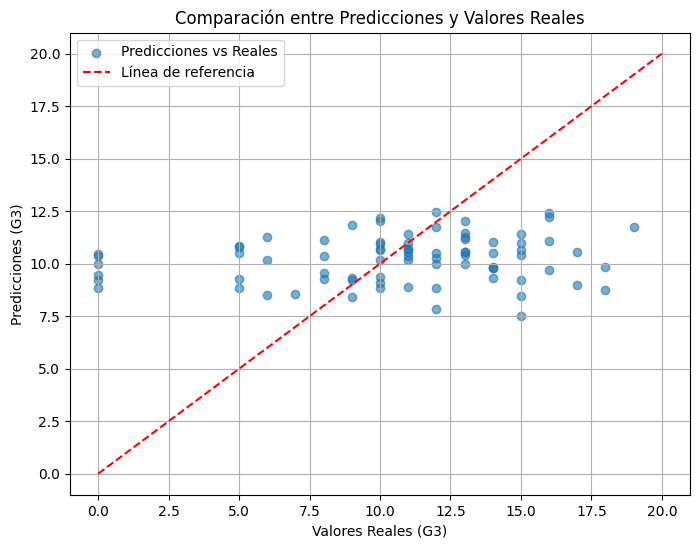

In [ ]:
# Importar librerías necesarias
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Asegurarse de que los datos estén en formato numérico
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)
y_train = np.array(y_train, dtype=float)
y_test = np.array(y_test, dtype=float)

# Ajustar el modelo de regresión lineal múltiple
modelo = sm.OLS(y_train, sm.add_constant(X_train))  # Se agrega la constante para el intercepto
resultado = modelo.fit()

# Imprimir el resumen del modelo
print(resultado.summary())

# Obtener el valor de R²
r_squared = resultado.rsquared
print(f"El valor de R² es: {r_squared}")

# Hacer predicciones con el modelo ajustado
y_pred = resultado.predict(sm.add_constant(X_test))

# Crear la gráfica de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicciones vs Reales")

# Dibujar la línea de referencia (línea roja con pendiente 1)
plt.plot([0, 20], [0, 20], color="red", linestyle="--", label="Línea de referencia")

# Añadir etiquetas y leyenda
plt.xlabel("Valores Reales (G3)")
plt.ylabel("Predicciones (G3)")
plt.title("Comparación entre Predicciones y Valores Reales")
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()

El modelo fue entrenado con variables importantes y términos de interacción para predecir la calificación final (G3) de los estudiantes. Sin embargo, los resultados muestran que la predicción no fue precisa, lo que se refleja en un valor de R^2 bajo. Esto indica que el modelo no logra explicar bien las calificaciones finales, posiblemente porque hay otros factores que influyen en G3 y no fueron incluidos.

También se observa que algunas variables tienen valores de p-value altos, lo que significa que su impacto en la calificación final no es significativo. Esto sugiere que la relación entre los datos y G3 podría no ser completamente lineal o que hay variabilidad en los datos que afecta la predicción.

A pesar de esto, el modelo sigue siendo útil para identificar patrones generales en los datos y entender qué factores pueden influir en el rendimiento académico.